# Emulators: Measuring performance

This example illustrates how different neural networks perform in emulating the log-likelihood surface of a time series and in Bayesian inference, using a two-step MCMC procedure with emulator neural networks [Emulated Metropolis MCMC](../sampling/first-example.ipynb).

It follows on from [Emulators: First example](../mcmc/first-example-emulator.ipynb)

Like in the first example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("Gaussian noise:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

Gaussian noise: 24.898095903089327


Using matplotlib and seaborn (optional - for styling), I look at the noisy time series I just simulated:

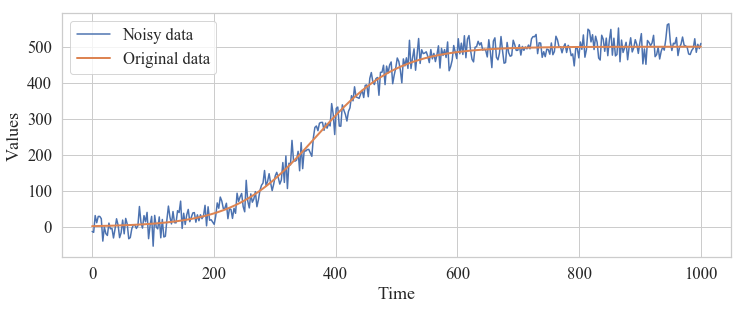

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Original data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions, using the rescaled true parameters:

In [12]:
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

## Creating training data

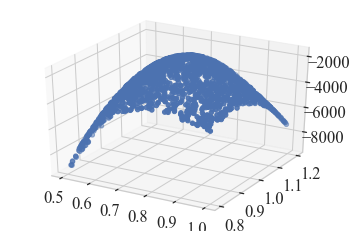

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.model_selection import train_test_split

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

## Training various NNs with different setups

In [14]:
layers = list(range(1, 11, 1))
neurons = [ 2**j for j in range(1,6+1) ]
epochs = 1000
print("NN layers:", layers)
print("NN hidden units:", neurons)

# Compute all possible permutations of NN parameters
hyperparams = [[i, j] for i in layers  
                      for j in neurons] 

print ("All possible layer and hidden units permutations are: " + str(hyperparams)) 
print(len(hyperparams), "sets of hyperparameters")

NN layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
NN hidden units: [2, 4, 8, 16, 32, 64]
All possible layer and hidden units permutations are: [[1, 2], [1, 4], [1, 8], [1, 16], [1, 32], [1, 64], [2, 2], [2, 4], [2, 8], [2, 16], [2, 32], [2, 64], [3, 2], [3, 4], [3, 8], [3, 16], [3, 32], [3, 64], [4, 2], [4, 4], [4, 8], [4, 16], [4, 32], [4, 64], [5, 2], [5, 4], [5, 8], [5, 16], [5, 32], [5, 64], [6, 2], [6, 4], [6, 8], [6, 16], [6, 32], [6, 64], [7, 2], [7, 4], [7, 8], [7, 16], [7, 32], [7, 64], [8, 2], [8, 4], [8, 8], [8, 16], [8, 32], [8, 64], [9, 2], [9, 4], [9, 8], [9, 16], [9, 32], [9, 64], [10, 2], [10, 4], [10, 8], [10, 16], [10, 32], [10, 64]]
60 sets of hyperparameters


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]
scaling_factors = [1/50, 500]

mapes = []
rhats_nn = []
rhats_emu = []
w_distances_r_nn = []
w_distances_k_nn = []
w_distances_r_emu = []
w_distances_k_emu = []
acceptance_rates1 = []
acceptance_rates2 = []

# Run standard Metropolis Hastings MCMC
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
mcmc.set_max_iterations(30000) # Add stopping criterion
mcmc.set_log_to_screen(False) # Disable logging mode
metropolis_chains = mcmc.run()
# Revert scaling
metropolis_chains_rescaled = np.copy(metropolis_chains)
metropolis_chain_rescaled = metropolis_chains_rescaled[0]
metropolis_chain_rescaled = metropolis_chain_rescaled[10000:]
metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                              for chain in metropolis_chains])
metropolis_chain = metropolis_chains[0]
metropolis_chain = metropolis_chain[10000:]
# Check convergence using rhat criterion
rhat = pints.rhat_all_params(metropolis_chains_rescaled[:, 10000:, :])
metropolis_chain_r = np.array([sample[0] for sample in metropolis_chain])
metropolis_chain_k = np.array([sample[1] for sample in metropolis_chain])

# Create a number of splits along each axis
test_splits = 50
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

for i, p in enumerate(hyperparams):
    print("Testing NN with parameters (layers, neurons, epochs):", p)
    # Train NN with given parameters
    emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
    emu.set_parameters(layers=p[0], neurons=p[1], hidden_activation='relu', activation='linear', learning_rate=0.0001)
    hist = emu.fit(epochs=epochs, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
    log_posterior_emu = pints.LogPosterior(emu, log_prior)
    
    # Compute mean abs. percentage error between likelihood surfaces
    emu_prediction = pints.predict_grid(emu, test_data)
    mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
    mapes.append(mape)    
    
    # Run Metropolis Hastings MCMC using NN posterior
    # Create mcmc routine
    mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(30000) # Add stopping criterion
    mcmc.set_log_to_screen(False) # Disable logging mode
    chains_emu = mcmc.run()
    # Revert scaling
    chains_emu_rescaled = np.copy(chains_emu)
    chain_emu_rescaled = chains_emu_rescaled[0]
    chain_emu_rescaled = chain_emu_rescaled[10000:]
    chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])
    chain_emu = chains_emu[0]
    chain_emu = chain_emu[10000:]
    # Check convergence using rhat criterion
    rhat = pints.rhat_all_params(chains_emu_rescaled[:, 10000:, :])
    rhats_nn.append(rhat)
    
    
    # Run 2-step Metropolis Hastings MCMC
    # Create mcmc routine
    mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)
    mcmc.set_max_iterations(30000) # Add stopping criterion
    mcmc.set_log_to_screen(False) # Disable logging mode
    emulated_chains = mcmc.run()
    # Get acceptance rates per stage of the 2-step procedure
    rates = mcmc.acceptance_rates()
    acceptance_rates1.append(rates[0]) # Chain 1
    acceptance_rates2.append(rates[1]) # Chain 2
    # Revert scaling
    emulated_chains_rescaled = np.copy(emulated_chains)
    emulated_chain_rescaled = emulated_chains_rescaled[0]
    emulated_chain_rescaled = emulated_chain_rescaled[10000:]
    emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                                for chain in emulated_chains])
    emulated_chain = emulated_chains[0]
    emulated_chain = emulated_chain[10000:]
    # Check convergence using rhat criterion
    rhat = pints.rhat_all_params(emulated_chains_rescaled[:, 10000:, :])
    rhats_emu.append(rhat)
    
    
    # Compute Wasserstein distance
    chain_emu_r = np.array([sample[0] for sample in chain_emu])
    chain_emu_k = np.array([sample[1] for sample in chain_emu])
    emulated_chain_r = np.array([sample[0] for sample in emulated_chain])
    emulated_chain_k = np.array([sample[1] for sample in emulated_chain])

    w_distance1_r = stats.wasserstein_distance(metropolis_chain_r, chain_emu_r)
    w_distance1_k = stats.wasserstein_distance(metropolis_chain_k, chain_emu_k)
    w_distance2_r = stats.wasserstein_distance(metropolis_chain_r, emulated_chain_r)
    w_distance2_k = stats.wasserstein_distance(metropolis_chain_k, emulated_chain_k)
    
    w_distances_r_nn.append(w_distance1_r)
    w_distances_k_nn.append(w_distance1_k)
    w_distances_r_emu.append(w_distance2_r)
    w_distances_k_emu.append(w_distance2_k)

    print(p, mape, w_distance1_r, w_distance1_k, w_distance2_r, w_distance2_k)
    

Testing NN with parameters (layers, neurons, epochs): [1, 2]
[1, 2] 0.2154896808132698 0.005015464501804422 96.7270823505599 3.1251572613548264e-06 0.10977615171075523
Testing NN with parameters (layers, neurons, epochs): [1, 4]
[1, 4] 0.27445411676756876 0.004979585547959284 97.5343291585153 1.9749631213085814e-06 0.048727231884332464
Testing NN with parameters (layers, neurons, epochs): [1, 8]
[1, 8] 0.1196072294567432 0.0021305269133935264 99.02911003196999 0.0006711304701835008 0.8628962848263112
Testing NN with parameters (layers, neurons, epochs): [1, 16]
[1, 16] 0.06473994727168315 0.0001797502154658045 3.10732811286384 0.0001541640822480931 8.156777274046043
Testing NN with parameters (layers, neurons, epochs): [1, 32]
[1, 32] 0.02730683640347039 0.0006009909851450706 15.563307593571325 9.11256843297706e-06 1.1784746567275535
Testing NN with parameters (layers, neurons, epochs): [1, 64]
[1, 64] 0.010874075624534917 3.824392568774964e-05 3.1287475013292587 2.3449958947215663e-06

[9, 2] 0.12349960374482494 0.00031596401332132485 36.11959874078197 2.454379109940422e-06 0.05685347070545375
Testing NN with parameters (layers, neurons, epochs): [9, 4]
[9, 4] 0.2743818782937977 0.0050059721757688405 97.93302659639355 2.147470606510315e-06 0.14740505572532026
Testing NN with parameters (layers, neurons, epochs): [9, 8]
[9, 8] 0.012832167059998107 8.32388229144075e-05 1.0932097902389852 2.847063169139834e-06 0.1254434231247553
Testing NN with parameters (layers, neurons, epochs): [9, 16]
[9, 16] 0.016515754124547283 9.750966934123298e-05 5.745857709189522 5.152329738396836e-06 0.15200517932268892
Testing NN with parameters (layers, neurons, epochs): [9, 32]
[9, 32] 0.01669840653121829 5.60670350558764e-05 4.3044520837609825 2.5080900682510374e-06 0.40536574239942785
Testing NN with parameters (layers, neurons, epochs): [9, 64]
[9, 64] 0.03235615768898642 6.009606812740495e-05 1.230399626631351 1.0567733776769742e-05 0.2891726627720512
Testing NN with parameters (layer

In [16]:
mapes[:5]

[0.2154896808132698,
 0.27445411676756876,
 0.1196072294567432,
 0.06473994727168315,
 0.02730683640347039]

In [17]:
w_distances_r_emu[:5]

[3.1251572613548264e-06,
 1.9749631213085814e-06,
 0.0006711304701835008,
 0.0001541640822480931,
 9.11256843297706e-06]

In [18]:
w_distances_k_emu[:5]

[0.10977615171075523,
 0.048727231884332464,
 0.8628962848263112,
 8.156777274046043,
 1.1784746567275535]

In [50]:
acceptance_rates2[:10]
#self._acceptance, self._acceptance1, self._acceptance2

[(0.22340000000000004, 0.6307666666666643, 0.3541721714315926),
 (0.29240000000000277, 0.6782333333333338, 0.4311200668403243),
 (0.2010999999999995, 0.6170666666666705, 0.3258967156439039),
 (0.04883333333333329, 0.4854666666666635, 0.10059049711617742),
 (0.060433333333333304, 0.5373666666666731, 0.11246200607902594),
 (0.11060000000000006, 0.4233666666666668, 0.26123927249822854),
 (0.34930000000000133, 0.7242333333333335, 0.48230312514383195),
 (0.28113333333333335, 0.6737333333333345, 0.4172768652285764),
 (0.1935333333333335, 0.6195999999999996, 0.3123520550893054),
 (0.026533333333333346, 0.5118333333333421, 0.051839791598826866)]

In [37]:
chain1_acceptance_rates2 = [r[2] for r in acceptance_rates1]
chain2_acceptance_rates2 = [r[2] for r in acceptance_rates2]
chain1_acceptance_rates2[:5]

[0.35763598326359985,
 0.43042836041359445,
 0.13782504456875772,
 0.06651812045350189,
 0.09817467359614795]

In [38]:
# Sort according to MAPEs
idx = np.array(mapes).argsort()
acceptance2_sorted1 = np.array(chain1_acceptance_rates2)[idx]
acceptance2_sorted2 = np.array(chain2_acceptance_rates2)[idx]

w_distances_k_sorted = np.array(w_distances_k_emu)[idx]
w_distances_r_sorted = np.array(w_distances_r_emu)[idx]
mapes_sorted = np.array(mapes)[idx]

#mean_acceptance2 = [np.mean(r[0]+r[1]+r[2]) for r in acceptance_rates2]
#mean_acceptance2_sorted = np.array(mean_acceptance2)[idx]

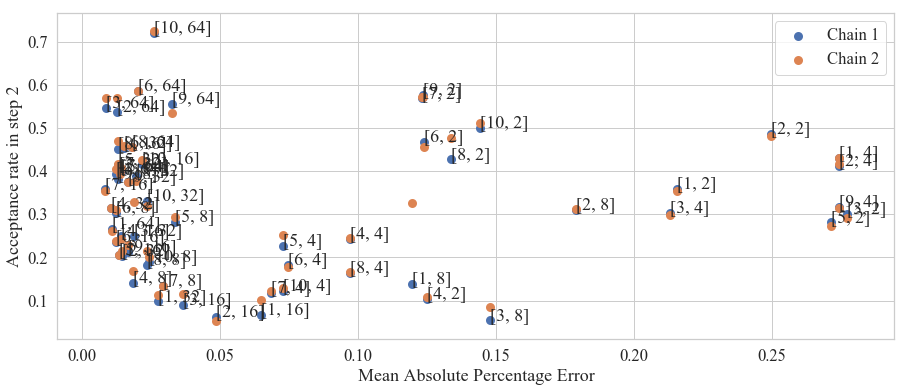

In [49]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Mean Absolute Percentage Error')
plt.ylabel('Acceptance rate in step 2')
ax.scatter(mapes, chain1_acceptance_rates2, lw=3, label='Chain 1')
ax.scatter(mapes, chain2_acceptance_rates2, lw=3, label='Chain 2')
#plt.plot(mapes, w_distances_k_sorted, lw=2, label='Wasserstein distance of samples')
#hyperparams_sorted = np.array(hyperparams)[idx]
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (mapes[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

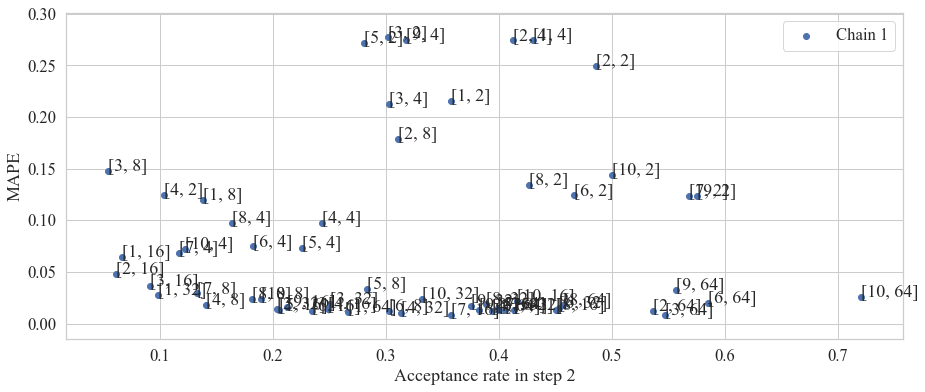

In [45]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.ylabel('MAPE')
plt.xlabel('Acceptance rate in step 2')
ax.scatter(chain1_acceptance_rates2, mapes, label='Chain 1')
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (chain1_acceptance_rates2[i], mapes[i]))
plt.legend()
plt.show()